<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-03-03-tree-based-models-gradient-boosted-xboost-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.3 Extreme Gradient Boosting (XGBoost)

XGBoost (Extreme Gradient Boosting) is a scalable and efficient machine learning algorithm for supervised learning tasks, particularly effective for regression, classification, and ranking problems. It is an optimized implementation of gradient boosting, a method that builds an ensemble of weak prediction models (typically decision trees) in a sequential manner to produce a strong predictive model. XGBoost is widely used due to its high performance, flexibility, and ability to handle large datasets with missing values, regularization, and parallel processing. This notebook will provide an overview of XGBoost, explain how it works, and demonstrate how to implement it in R for classification and regression tasks.



## Overview

XGBoost constructs a model by combining multiple decision trees, where each tree corrects the errors of the previous ones. It uses gradient boosting, which minimizes a loss function by iteratively adding trees, with each tree trained to predict the residuals (errors) of the prior ensemble. XGBoost enhances this process with additional features like regularization, second-order gradient optimization, and efficient handling of sparse data.


### Key Features of XGBoost

- **Gradient Boosting Framework**: Combines weak learners (typically decision trees) into a strong predictive model.
- **Optimization**: Uses advanced techniques like second-order gradient optimization (Newton boosting) for faster convergence.
- **Regularization**: Includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting.
- **Parallelization**: Supports parallel and distributed computing for faster training.
- **Handling Missing Data**: Automatically handles missing values by learning the best imputation strategy.
- **Feature Importance**: Provides insights into feature importance for model interpretability.
- **Flexibility**: Supports custom loss functions and evaluation metrics.

### How XGBoost Works

XGBoost is based on the gradient boosting framework, which iteratively combines weak learners (typically decision trees) to form a strong predictive model. It optimizes a loss function while adding regularization to prevent overfitting. Below is a detailed explanation of how XGBoost works, including the key equations.

1.  Objective Function

The `objective function` is a mathematical expression that a model aims to minimize during training. It quantifies the model’s performance by combining a loss function, which measures prediction error, with a regularization term, which controls model complexity to prevent overfitting. In XGBoost, the objective function guides the construction of decision trees in the gradient boosting process.

The core of XGBoost is to minimize an objective function that combines a loss function and a regularization term. For a dataset with $n$samples and $m$ features, the objective function at iteration $t$ is:

$$ \text{Obj}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^t \Omega(f_k) $$

-   $l(y_i, \hat{y}_i^{(t)})$: Loss function measuring the difference between the true label $y_i$ and the predicted value $\hat{y}_i^{(t)}$.

Common loss functions include:

-   Mean Squared Error (MSE) for regression:

$$ $l(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2 $$

-   Log-loss for binary classification:

$$ l(y_i, \hat{y}_i) = -[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)] $$

-   $\Omega(f_k)$: Regularization term for the $k$-th tree to penalize model complexity and prevent overfitting:

$$ \Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2 $$

-   $T$: Number of leaves in the tree.

-   $w_j$: Weight (score) of the $j$-th leaf.

-   $\gamma$: Penalty for the number of leaves (controls tree size).

-   $\lambda$: L2 regularization parameter on leaf weights.

2.  Additive Training

XGBoost builds the model additively. At iteration $t$, the prediction for sample $i$ is:

$$ \hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta f_t(x_i) $$

-   $f_t(x_i)$: Output of the $t$-th tree for input $x_i$.

-   $\eta$: Learning rate (shrinkage factor) to scale the contribution of each tree.

The goal is to find the tree $f_t$ that minimizes the objective function.

3.  Second-Order Approximation

To optimize the objective function, XGBoost uses a second-order Taylor approximation of the loss function. For a given sample ( i ), the loss function is approximated as:

$$ l(y_i, \hat{y}_i^{(t)}) \approx l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 $$

-   $g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})$: First-order gradient (gradient of the loss w.r.t. the prediction).

-   $h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})$: Second-order gradient (Hessian of the loss).

The objective function becomes:

$$ \text{Obj}^{(t)} \approx \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t) $$

4.  Tree Structure Optimization

Each tree partitions the data into leaves, and each leaf has a weight $w_j$. For a given tree structure, the optimal leaf weight for leaf $j$ is:

$$ w_j^* = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda} $$

-   $I_j$: Set of samples in leaf $j$.

-   The corresponding objective value for the leaf is:

$$ \text{Obj}_j = -\frac{1}{2} \frac{(\sum_{i \in I_j} g_i)^2}{\sum_{i \in I_j} h_i + \lambda} + \gamma $$

The algorithm greedily searches for the best split by maximizing the gain:

$$ \text{Gain} = \frac{1}{2} \left[ \frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} - \frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda} \right] - \gamma $$

-   $I_L$, $I_R$: Left and right child nodes after a split.

-   $I$: Parent node before the split.

Here below is a flowchart illustrating the XGBoost workflow:


![alt text](http://drive.google.com/uc?export=view&id=1Dc3bkYebbiQG5D-q-LOG0BbDeATZliXn
)








### Advantages of XGBoost

1. `High Performance`: Consistently outperforms other algorithms in machine learning competitions (e.g., Kaggle) due to its accuracy and efficiency.
2. `Scalability`: Handles large datasets efficiently through parallel processing and optimized memory usage.
3. `Robustness to Overfitting`: Built-in regularization (L1 and L2) and tree pruning reduce overfitting compared to traditional gradient boosting.
4. `Handles Diverse Data`: Works well with structured/tabular data, missing values, and categorical features (with preprocessing).
5. `Flexibility`: Supports a wide range of tasks (classification, regression, ranking) and custom optimization objectives.
6. `Feature Importance`: Provides clear insights into which features drive predictions, aiding interpretability.
7. `Community and Ecosystem`: Widely used, with strong community support, extensive documentation, and integration with tools like scikit-learn and Spark.

### Limitations of XGBoost

1. `Complexity`: Requires careful hyperparameter tuning (e.g., learning rate, max depth, number of trees) to achieve optimal performance, which can be time-consuming.
2. `Computational Cost`: Despite optimizations, training can be resource-intensive for very large datasets or deep trees compared to simpler models like linear regression.
3. `Not Ideal for Unstructured Data`: Less effective for unstructured data (e.g., images, text) compared to deep learning models like neural networks.
4. `Interpretability`: While feature importance is provided, the ensemble nature of many trees can make it harder to interpret compared to single decision trees or linear models.
5. `Sensitivity to Noisy Data`: Can overfit on noisy datasets if not properly tuned or regularized.
6. `Cold Start Problem`: Struggles with new or unseen data patterns unless retrained, unlike online learning algorithms.
7. `Over-reliance on Tuning`: Performance heavily depends on hyperparameter optimization, which requires expertise or extensive grid search.


### Key Tunable Hyperparameters in XGBoost

1. General Parameters

- `booste`: Type of learner (`gbtree`, `gblinear`, `dart`). Default: `gbtree`.

2. Booster Parameters

- `eta (learning_rate)`: Step size shrinkage (0.01–0.3). Default: 0.3.
- `max_depth`: Max tree depth (3–10). Default: 6.
- `min_child_weight`: Min sum of instance weights in a child (1–10). Default: 1.
- `subsample`: Fraction of data sampled per tree (0.5–1). Default: 1.
- `colsample_bytree`: Fraction of features per tree (0.5–1). Default: 1.
- `colsample_bylevel`: Fraction of features per level (0.5–1). Default: 1.
- `colsample_bynode`: Fraction of features per node (0.5–1). Default: 1.
- `gamma*` Min loss reduction for a split (0–5). Default: 0.
- `lambda (reg_lambda)`: L2 regularization on weights (0–10). Default: 1.
- `alpha (reg_alpha)`: L1 regularization on weights (0–1). Default: 0.

3. Training Parameters

- `n_estimators (num_boost_round)`: Number of trees (100–1000). Default: 100.
- `early_stopping_rounds`: Stops if no improvement (10–50). Default: None.

4. Task-Specific Parameters

- `objective`: Loss function (e.g., `reg:squarederror`, `binary:logistic`). Depends on task.
- *`eval_metric`: Evaluation metric (e.g., `rmse`, `logloss`, `auc`). Matches objective.

5. Tuning Tips

- Start with defaults, adjust `eta`, `max_depth`, `subsample`, `colsample_bytree` first.
- Use lower `eta` with more `n_estimators` for robustness.
- Increase `gamma`, `lambda`, `alpha` to reduce overfitting.
- Apply early stopping with a validation set.
- Use grid search, random search, or Bayesian optimization (e.g., Optuna).

### Differences Between XGBoost, GBM, LightGBM, and Random Forest

XGBoost, GBM (Gradient Boosting Machine), LightGBM, and Random Forest are all tree-based machine learning algorithms, but they differ in their approach, optimization techniques, and performance characteristics. Below is a detailed comparison of these algorithms, followed by a table summarizing their differences.

Here’s a table summarizing the key differences across **GBM**, **XGBoost**, **LightGBM**, and **Random Forest**:

| **Aspect**                  | **GBM**                                                                 | **XGBoost**                                                             | **LightGBM**                                                            | **Random Forest**                                                       |
|-----------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------|
| `Algorithm Type`          | Gradient boosting (sequential tree building)                            | Optimized gradient boosting                                             | Gradient boosting with histogram-based optimization                     | Bagging-based ensemble of independent trees                            |
| `Tree Construction`       | Sequential, additive (each tree corrects previous errors)               | Sequential, additive with regularization                                | Sequential, leaf-wise growth (splits best leaf)                        | Parallel, independent trees with bagging                               |
| `Optimization`            | Gradient descent (first-order)                                          | Second-order gradient (Newton boosting) for faster convergence          | Gradient-based one-side sampling (GOSS) and histogram binning           | No gradient optimization; uses random feature subsets and bagging       |
| `Speed`                   | Slower due to lack of parallelization and optimizations                 | Faster than GBM due to parallelization and caching                      | Faster than XGBoost for large datasets due to histogram-based approach  | Fast due to parallel tree construction, but no sequential optimization  |
| `Memory Efficiency`       | Moderate to high memory usage                                           | Improved memory efficiency over GBM                                     | Highly memory-efficient due to histogram binning                        | Moderate to high, depending on number of trees                         |
| `Regularization`          | Limited or none (depends on implementation)                            | L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting         | L1 and L2 regularization, similar to XGBoost                            | No explicit regularization; relies on randomness and averaging          |
| `Handling Missing Values` | Not natively supported (requires preprocessing)                        | Natively handles missing values by learning optimal split directions    | Natively handles missing values                                         | Not natively supported (requires imputation)                           |
| `Scalability`             | Poor for large datasets due to sequential processing                    | Good scalability with parallel and distributed computing                | Excellent for large datasets due to histogram-based approach            | Good scalability due to parallel tree building                         |
| `Categorical Features`    | Requires preprocessing (e.g., one-hot encoding)                         | Requires preprocessing, but handles sparse data well                    | Native support for categorical features (no encoding needed)            | Requires preprocessing (e.g., one-hot encoding)                         |
| `Feature Importance`      | Supported, but less refined                                            | Detailed feature importance (gain, cover, frequency)                    | Detailed feature importance, similar to XGBoost                         | Feature importance based on Gini impurity or permutation importance     |
| `Overfitting Control`     | Prone to overfitting without careful tuning                             | Strong control via regularization and early stopping                    | Strong control via regularization and efficient leaf-wise growth        | Less prone to overfitting due to bagging and random feature selection   |
| `Interpretability`        | Moderate (complex due to sequential trees)                              | Moderate, but feature importance aids interpretability                  | Moderate, similar to XGBoost                                            | Relatively interpretable due to independent trees                      |
|`Use Case Suitability`    | General-purpose, smaller datasets                                       | High-performance tasks (e.g., Kaggle competitions, tabular data)        | Large-scale datasets, high-dimensional data                            | General-purpose, robust for noisy data, tabular data                   |
| `Implementation*`        | Available in scikit-learn, R, etc.                                      | Dedicated library (`xgboost`), integrates with scikit-learn, Spark      | Dedicated library (`lightgbm`), integrates with scikit-learn, Spark     | Available in scikit-learn, R, and other libraries                      |
| `GPU Support`            | Limited or none (depends on implementation)                            | Supported for faster training                                           | Strong GPU support for large-scale training                            | Limited or no GPU support in most implementations                      |
| `Hyperparameter Tuning`   | Moderate tuning complexity                                             | Extensive tuning (learning rate, max depth, etc.)                      | Moderate tuning, but fewer parameters than XGBoost                      | Simpler tuning (e.g., number of trees, max features)                   |
| `Limitations`             | Slow, lacks advanced optimizations, no native missing value handling    | Requires tuning, less effective for unstructured data                   | May overfit with leaf-wise growth if not tuned properly                | Less accurate than boosting for complex patterns, no sequential learning|



### Key Distinctions

1. Boosting vs. Bagging

   - GBM, XGBoost, and LightGBM use **boosting**, where trees are built sequentially to correct errors, making them more powerful for capturing complex patterns but prone to overfitting if not tuned.
   - Random Forest uses **bagging**, building independent trees in parallel, which is faster and more robust to noise but may not capture intricate patterns as effectively.

2. Optimization and Speed

   - GBM is the slowest due to its basic implementation and lack of parallelization.
   - XGBoost improves on GBM with parallel processing and second-order optimization.
   - LightGBM is optimized for speed and memory efficiency, especially for large datasets, using histogram-based techniques and leaf-wise growth.
   - Random Forest is fast due to parallel tree construction but lacks the iterative optimization of boosting methods.

3. Scalability and Data Handling

   - LightGBM excels with large, high-dimensional datasets due to its histogram-based approach and native categorical feature support.
   - XGBoost is scalable but slightly less efficient than LightGBM for very large datasets.
   - GBM struggles with large datasets due to its sequential nature.
   - Random Forest scales well but requires preprocessing for missing values and categorical features.

4. Overfitting and Robustness

   - XGBoost and LightGBM include regularization to control overfitting, but their sequential nature makes them sensitive to noise if not tuned.
   - Random Forest is inherently robust to overfitting due to bagging and randomness but may underperform on complex tasks.
   - GBM is prone to overfitting without careful tuning or regularization.

5. Use Cases

   - `GBM`: Suitable for smaller datasets or when simplicity is preferred, but less common in modern applications.
   - `XGBoost`: Widely used in competitions and tabular data tasks requiring high accuracy (e.g., finance, healthcare).
   - `LightGBM`: Preferred for large-scale datasets, such as in big data environments or real-time applications.
   - `Random Forest`: Ideal for quick prototyping, noisy data, or when interpretability and robustness are prioritized.


## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314976 sha256=2e13201d406d9d6191f3b10476c47d4a7cdb0413940e5e772f2bc7552774a6a3
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Extreme Gradient Boosting from Scratch

Fitting an `XGBoost` model manually without using R packages like {xgboost} is a complex task because XGBoost relies on optimized implementations for gradient boosting, tree construction, and parallel processing. However, it’s possible to implement a simplified version of the XGBoost algorithm from scratch in R by following its core principles: gradient boosting with decision trees, second-order gradient optimization, and regularization. This requires manually coding the tree construction, gradient and Hessian calculations, and the objective function optimization, which is computationally intensive and less efficient than the optimized {xgboost} package. Below, I’ll explain how to implement a basic version of XGBoost for regression, focusing on the mathematical framework and providing R code without external packages. The explanation will include equations and a step-by-step process to make it clear.

### Data Generation

- Generates synthetic data: 100 samples with 2 features (X).
- Regression target: `y_reg = 3*X1 + 2*X2 + noise`.
- Classification target: `y_class = 1 if X1 + X2 > 1, else 0`.






In [ ]:
%%R
# Data Generation
set.seed(123)
n <- 100
X <- matrix(runif(n * 2), ncol = 2)  # 2 features
y_reg <- 3 * X[, 1] + 2 * X[, 2] + rnorm(n, 0, 0.1)  # Regression target
y_class <- as.integer(X[, 1] + X[, 2] > 1)  # Classification target (0 or 1)

### Initialization and Parameters

- Sets hyperparameters: `n_trees=10`, `eta=0.1`, `max_depth=3`, `min_child_weight=1`, `lambda=1`, `gamma=0.`
- Initializes predictions to 0 (regression) or 0.5 (classification).


In [ ]:
%%R
# Initialization and Parameters
n_trees <- 10
eta <- 0.1
max_depth <- 3
min_child_weight <- 1
lambda <- 1
gamma <- 0

# Loss functions
mse_loss <- function(y, pred) (y - pred)^2
logloss <- function(y, pred) {
  pred <- pmin(pmax(pred, 1e-15), 1 - 1e-15)  # Avoid log(0)
  -y * log(pred) - (1 - y) * log(1 - pred)
}

### Gradient and Hessian Calculation

To compute the `gradients` and `Hessian`s for regression and classification tasks, we define a function that calculates these values based on the predictions and true labels. The gradients represent the first derivative of the loss function, while the Hessians represent the second derivative.

In [ ]:
%%R
# Gradient and Hessian Calculation
compute_grad_hess <- function(y, pred, task = "regression") {
  if (task == "regression") {
    list(grad = 2 * (pred - y), hess = rep(2, length(y)))
  } else {
    pred <- pmin(pmax(pred, 1e-15), 1 - 1e-15)  # Stabilize for classification
    list(grad = (pred - y) / (pred * (1 - pred)), hess = 1 / (pred * (1 - pred)))
  }
}

### Finding the Best Split

To find the best split for a given feature, we iterate through unique values of that feature and calculate the gain from splitting the data at each value. The gain is computed using the gradients and Hessians for the left and right splits, following the XGBoost formula. Applies `min_child_weight`, `lambda`, and `gamma` to control splits.




In [ ]:
%%R
# Finding the Best Split
find_best_split <- function(X, grad, hess, feature_idx, min_child_weight, lambda, gamma) {
  n <- nrow(X)
  values <- sort(unique(X[, feature_idx]))
  best_gain <- -Inf
  best_split <- NULL
  total_G <- sum(grad)
  total_H <- sum(hess)

  for (val in values[-length(values)]) {
    left_idx <- which(X[, feature_idx] <= val)
    right_idx <- which(X[, feature_idx] > val)

    if (length(left_idx) == 0 || length(right_idx) == 0) next

    G_left <- sum(grad[left_idx])
    H_left <- sum(hess[left_idx])
    G_right <- total_G - G_left
    H_right <- total_H - H_left

    if (H_left < min_child_weight || H_right < min_child_weight) next

    gain <- 0.5 * ((G_left^2 / (H_left + lambda)) + (G_right^2 / (H_right + lambda)) -
                   (total_G^2 / (total_H + lambda))) - gamma

    if (gain > best_gain) {
      best_gain <- gain
      best_split <- list(feature = feature_idx, value = val, gain = gain)
    }
  }
  best_split
}

### Building the Decision Tree

To build the decision tree, we recursively split the data based on the best splits found in the previous step. The tree construction continues until reaching the maximum depth or when no further splits improve the gain. Each leaf node is assigned a weight based on the gradients and Hessians of the samples in that leaf. Computes optimal leaf weights: `-sum(grad)/(sum(hess) + lambda)`.

In [ ]:
%%R
# Building the Decision Tree
build_tree <- function(X, grad, hess, depth, max_depth, min_child_weight, lambda, gamma) {
  if (depth >= max_depth || nrow(X) < 2) {
    w <- -sum(grad) / (sum(hess) + lambda)
    return(list(leaf = TRUE, weight = w))
  }

  best_split <- NULL
  best_gain <- -Inf
  for (feature_idx in 1:ncol(X)) {
    split <- find_best_split(X, grad, hess, feature_idx, min_child_weight, lambda, gamma)
    if (!is.null(split) && split$gain > best_gain) {
      best_gain <- split$gain
      best_split <- split
    }
  }

  if (is.null(best_split) || best_gain <= 0) {
    w <- -sum(grad) / (sum(hess) + lambda)
    return(list(leaf = TRUE, weight = w))
  }

  left_idx <- which(X[, best_split$feature] <= best_split$value)
  right_idx <- which(X[, best_split$feature] > best_split$value)

  left_subtree <- build_tree(X[left_idx, , drop = FALSE], grad[left_idx], hess[left_idx],
                            depth + 1, max_depth, min_child_weight, lambda, gamma)
  right_subtree <- build_tree(X[right_idx, , drop = FALSE], grad[right_idx], hess[right_idx],
                             depth + 1, max_depth, min_child_weight, lambda, gamma)

  list(leaf = FALSE, feature = best_split$feature, value = best_split$value,
       left = left_subtree, right = right_subtree)
}

### Predicting with the Tree

To make predictions with the decision tree, we traverse the tree based on the feature values of the input data. If we reach a leaf node, we return the weight assigned to that leaf. This function recursively checks the feature value against the split value to navigate through the tree. Applies sigmoid transformation for classification predictions.

In [ ]:
%%R
# Predicting with the Tree
predict_tree <- function(tree, x) {
  if (tree$leaf) return(tree$weight)
  if (x[tree$feature] <= tree$value) {
    predict_tree(tree$left, x)
  } else {
    predict_tree(tree$right, x)
  }
}

### Main Boosting Loop

The main boosting loop iterates through the number of trees to be built. In each iteration, it computes the gradients and Hessians for the current predictions, builds a decision tree based on these values, and updates the predictions by adding the tree's output scaled by the learning rate (`eta`). The predictions are updated for both regression (direct addition) and classification (applying a sigmoid function).

In [ ]:
%%R
# Main Boosting Loop
xgboost_train <- function(X, y, n_trees, eta, max_depth, min_child_weight, lambda, gamma, task = "regression") {
  n <- nrow(X)
  pred <- rep(ifelse(task == "regression", 0, 0.5), n)
  trees <- list()

  for (t in 1:n_trees) {
    gh <- compute_grad_hess(y, pred, task)
    tree <- build_tree(X, gh$grad, gh$hess, 0, max_depth, min_child_weight, lambda, gamma)
    trees[[t]] <- tree

    for (i in 1:n) {
      pred[i] <- pred[i] + eta * predict_tree(tree, X[i, ])
      if (task == "classification") pred[i] <- 1 / (1 + exp(-pred[i]))  # Sigmoid
    }
  }

  list(trees = trees, pred = pred, task = task)
}

### Final Prediction and Evaluation

- Predicts using the ensemble of trees.
- Evaluates regression with `MSE` and classification with `log-loss` and `accuracy`.


In [ ]:
%%R
# Final Prediction and Evaluation
predict_xgboost <- function(model, X) {
  n <- nrow(X)
  pred <- rep(ifelse(model$task == "regression", 0, 0.5), n)

  for (tree in model$trees) {
    for (i in 1:n) {
      pred[i] <- pred[i] + eta * predict_tree(tree, X[i, ])
      if (model$task == "classification") pred[i] <- 1 / (1 + exp(-pred[i]))
    }
  }
  pred
}

# Evaluation Metrics
mse <- function(y_true, y_pred) mean((y_true - y_pred)^2)
logloss_eval <- function(y_true, y_pred) {
  y_pred <- pmin(pmax(y_pred, 1e-15), 1 - 1e-15)
  mean(-y_true * log(y_pred) - (1 - y_true) * log(1 - y_pred))
}
accuracy <- function(y_true, y_pred) mean(y_true == (y_pred > 0.5))

### Train and Evaluate Regression Model


In [ ]:
%%R
# Train and evaluate regression model
model_reg <- xgboost_train(X, y_reg, n_trees, eta, max_depth, min_child_weight, lambda, gamma, task = "regression")
pred_reg <- predict_xgboost(model_reg, X)
mse_reg <- mse(y_reg, pred_reg)
cat("Regression MSE:", mse_reg, "\n")

Regression MSE: 1.003863 


### Train and Evaluate Classification Model

In [ ]:
%%R
# Train and evaluate classification model
model_class <- xgboost_train(X, y_class, n_trees, eta, max_depth, min_child_weight, lambda, gamma, task = "classification")
pred_class <- predict_xgboost(model_class, X)
logloss_class <- logloss_eval(y_class, pred_class)
acc_class <- accuracy(y_class, pred_class)
cat("Classification Log-loss:", logloss_class, "\n")
cat("Classification Accuracy:", acc_class, "\n")

Classification Log-loss: 0.7281187 
Classification Accuracy: 0.48 


## Extreme Gradient Boosting with R

The `{xgboost}` package in R is an optimized implementation of the XGBoost (eXtreme Gradient Boosting) algorithm, a powerful and efficient machine learning method for supervised learning tasks like regression, classification, and ranking. It’s widely used for its high performance, scalability, and ability to handle complex datasets, making it a go-to tool for predicting outcomes. Below is a concise overview of the `{xgboost}` package, covering its purpose, key features, functionality, and how it can be applied to classification and regression problems.

Key Features of `{xgboost}`:

1.  `Gradient Boosting`:
    -   Builds sequential decision trees, each correcting errors of the previous ones, using gradient descent to minimize a loss function.
    -   Supports second-order gradient optimization (Hessian) for faster convergence.
2.  `Objective Functions`:
    -   Supports various tasks:
        -   Regression: `reg:squarederror` (MSE), `reg:linear` (deprecated).
        -   Classification: `binary:logistic`, `multi:softmax`, `multi:softprob`.
        -   Ranking: `rank:pairwise`.
    -   Custom objectives can be defined.
3.  `Regularization`:
    -   L1 (`alpha`) and L2 (`lambda`) penalties on leaf weights.
    -   Minimum child weight and maximum depth to control tree complexity.
    -   Gamma penalty for adding leaves.
4.  `Performance Optimization`:
    -   Parallel tree construction using multiple CPU cores.
    -   Approximate split finding for large datasets.
    -   Handles missing values automatically.
5.  `Flexibility`:
    -   Supports sparse data, categorical variables (via encoding), and custom evaluation metrics.
    -   Cross-validation and early stopping for optimal iterations.

Key Functions in `{xgboost}` are:

-   `xgb.DMatrix()`: Creates a data matrix optimized for XGBoost, handling numeric and categorical data efficiently.
-   `xgb.train()`: Trains the model with customizable parameters (e.g., `max.depth`, `eta`, `nrounds`).
-   `xgb.cv()`: Performs k-fold cross-validation to tune hyperparameters.
-   `xgb.importance()`: Computes feature importance based on gain, frequency, or cover.
-   `predict()`: Generates predictions for new data.
-   `xgb.save/load{}`: Saves and loads models for reuse.


### Check amd Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [ ]:
%%R
packages <- c('tidyverse',
              'plyr',
              'xgboost',
              'Metrics',
              'fastDummies',
              'ggpmisc'

         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



  tidyverse        plyr     xgboost     Metrics fastDummies     ggpmisc 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 


### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:ggpmisc"     "package:ggpp"        "package:fastDummies"
 [4] "package:Metrics"     "package:xgboost"     "package:plyr"       
 [7] "package:lubridate"   "package:forcats"     "package:stringr"    
[10] "package:dplyr"       "package:purrr"       "package:readr"      
[13] "package:tidyr"       "package:tibble"      "package:ggplot2"    
[16] "package:tidyverse"   "package:tools"       "package:stats"      
[19] "package:graphics"    "package:grDevices"   "package:utils"      
[22] "package:datasets"    "package:methods"     "package:base"       


### Regression with XGBoost

This section of tutorial will focus on using the XGBoost package to perform regression analysis. We will load the dataset, preprocess it, and then fit an XGBoost model for regression. The dataset will be split into training and testing sets, and we will evaluate the model's performance using RMSE (Root Mean Squared Error).

#### Data and Data Preparation



In [ ]:
%%R
# Load Boston Housing dataset
data("Boston", package = "MASS")

# Create a data frame with selected variables
df <- Boston %>%
  dplyr::select(medv, crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat)

# Convert to matrix (assuming 'me' was a typo; no mean calculation needed here)
m <- as.matrix(df)

# Split the dataset into training and testing sets
set.seed(123)  # For reproducibility
indices <- sample(1:nrow(df), size = 0.75 * nrow(df))
train <- m[indices, ]
test <- m[-indices, ]


#### Load the train and test data into the xgboost dataset object

The train and test datasets are converted into `xgb.DMatrix` objects, which are optimized data structures for XGBoost. This step is crucial for efficient training and prediction.

In [ ]:
%%R
# Define predictor and response variables in training set
train_x <- data.matrix(train[, -1])  # All columns except medv
train_y <- train[, 1]               # medv column

# Define predictor and response variables in testing set
test_x <- data.matrix(test[, -1])
test_y <- test[, 1]

# Define final training and testing sets
dtrain <- xgb.DMatrix(data = train_x, label = train_y)
dtest <- xgb.DMatrix(data = test_x, label = test_y)

#### Fit Initial Model with Fixed Parameters

Next, we'll fit the XGBoost model by using the `xgb.train()` function, which displays the training and testing RMSE (root mean squared error) for each round of boosting. We use a few tunning prameters with default values.

In [ ]:
%%R
#  Parameters for XGBoost model
params <- list(
  objective = "reg:squarederror",
  eval_metric = "rmse",
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 0.8,
  min_child_weight = 1,
  subsample = 0.8
)

#fit XGBoost model and display training and testing data at each round
initial_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,
  watchlist = list(train = dtrain, test = dtest),
  early_stopping_rounds = 10,
  verbose = 0
)



In [ ]:
%%R
summary(initial_model)

                Length Class              Mode       
handle              1  xgb.Booster.handle externalptr
raw             43986  -none-             raw        
best_iteration      1  -none-             numeric    
best_ntreelimit     1  -none-             numeric    
best_score          1  -none-             numeric    
best_msg            1  -none-             character  
niter               1  -none-             numeric    
evaluation_log      3  data.table         list       
call                7  -none-             call       
params              9  -none-             list       
callbacks           2  -none-             list       
feature_names      19  -none-             character  
nfeatures           1  -none-             numeric    


#### Predict and Evaluate Initial Model

In [ ]:
%%R
# Prediction and Evaluation
yhat_train_initial <- predict(initial_model, train_x)  # Use train_x (columns 2-14)
yhat_test_initial <- predict(initial_model, test_x)    # Use test_x (columns 2-14)

# Define RMSE function
RMSE <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

rmse_train_initial <- RMSE(train_y, yhat_train_initial)
rmse_test_initial <- RMSE(test_y, yhat_test_initial)
cat("Initial Model Training RMSE:", rmse_train_initial, "\n")
cat("Initial Model Testing RMSE:", rmse_test_initial, "\n")

Initial Model Training RMSE: 0.6862006 
Initial Model Testing RMSE: 3.863504 


#### Hyperparameter Tuning for the Best Parameters

To optimize the XGBoost model, we can perform cross-validation to find the best hyperparameters. This involves testing different combinations of parameters like `max_depth`, `eta`, and `nrounds` to minimize the RMSE on the validation set.


##### Define Parameter Grid and Initialize Variables

In [ ]:
%%R
# Hyperparameter Tuning for the Best Parameters
# Define Parameter Grid and Initialize Variables

params <- list(
  objective = "reg:squarederror",
  eval_metric = "rmse",
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 0.8,
  min_child_weight = 1,
  subsample = 0.8
)

# Cross-validation for hyperparameter tuning
param_grid <- expand.grid(
  max_depth = c(3, 6, 9),
  eta = c(0.1, 0.3, 0.5),
  min_child_weight = c(1, 3, 5)
)

best_params <- NULL
best_error <- Inf
cv_results <- data.frame()

for (i in 1:nrow(param_grid)) {
  params_cv <- list(
    objective = "reg:squarederror",
    eval_metric = "rmse",
    max_depth = param_grid$max_depth[i],
    eta = param_grid$eta[i],
    gamma = 0,
    colsample_bytree = 0.8,
    min_child_weight = param_grid$min_child_weight[i],
    subsample = 0.8
  )

  cv_model <- xgb.cv(
    params = params_cv,
    data = dtrain,
    nrounds = 200,
    nfold = 5,
    early_stopping_rounds = 10,
    verbose = 0
  )

  # Use test_rmse_mean for regression
  min_error <- min(cv_model$evaluation_log$test_rmse_mean)
  best_nrounds <- which.min(cv_model$evaluation_log$test_rmse_mean)

  # Populate cv_results
  cv_results <- rbind(cv_results, data.frame(
    max_depth = param_grid$max_depth[i],
    eta = param_grid$eta[i],
    min_child_weight = param_grid$min_child_weight[i],
    test_rmse = min_error,
    nrounds = best_nrounds
  ))

  if (min_error < best_error) {
    best_error <- min_error
    best_params <- params_cv
    best_params$nrounds <- best_nrounds
  }
}

##### The best parameters

In [ ]:
%%R
# Output results
cat("\nBest Parameters:\n")
print(best_params)


Best Parameters:
$objective
[1] "reg:squarederror"

$eval_metric
[1] "rmse"

$max_depth
[1] 3

$eta
[1] 0.3

$gamma
[1] 0

$colsample_bytree
[1] 0.8

$min_child_weight
[1] 1

$subsample
[1] 0.8

$nrounds
[1] 72



##### Train and Validate Model with Best Parameters

In [ ]:
%%R
# Train final model with best parameters
final_model <- xgb.train(
  params = best_params,
  data = dtrain,
  nrounds = best_params$nrounds,
  watchlist = list(train = dtrain, test = dtest),
  verbose = 0
)

[02:01:14] WARNING: src/learner.cc:767: 
Parameters: { "nrounds" } are not used.



##### Predictions and Evaluation

In [ ]:
%%R
# Predictions and Evaluation
yhat_train_final <- predict(final_model, train_x)
yhat_test_final <- predict(final_model, test_x)

# Train and test RMSE
rmse_train_final <- RMSE(train_y, yhat_train_final)
rmse_test_final <- RMSE(test_y, yhat_test_final)
cat("Final Model Training RMSE:", rmse_train_final, "\n")
cat("Final Model Testing RMSE:", rmse_test_final, "\n")


Final Model Training RMSE: 0.04151871 
Final Model Testing RMSE: 3.436067 


`geom_smooth()` using formula = 'y ~ x'


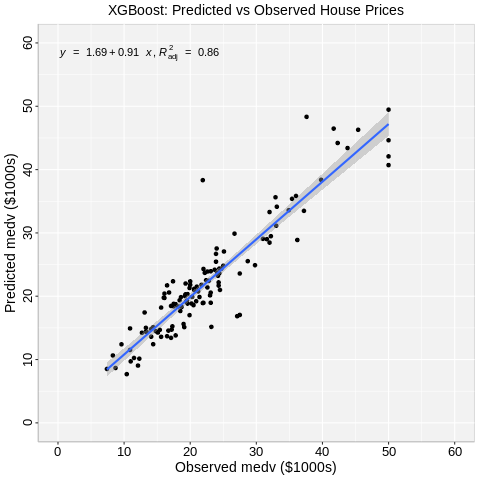

In [ ]:
%%R

# 1:1 Plot of Predicted vs Observed values
test_df <- data.frame(medv = test_y, medv_pred = yhat_test_final)

formula <- y ~ x

ggplot(test_df, aes(medv, medv_pred)) +
  geom_point() +
  geom_smooth(method = "lm") +
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("XGBoost: Predicted vs Observed House Prices") +
  xlab("Observed medv ($1000s)") + ylab("Predicted medv ($1000s)") +
  scale_x_continuous(limits = c(0, 60), breaks = seq(0, 60, 10)) +
  scale_y_continuous(limits = c(0, 60), breaks = seq(0, 60, 10)) +
  theme(
    panel.background = element_rect(fill = "grey95", colour = "gray75", size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 13, colour = "black"),
    axis.text.y = element_text(size = 13, angle = 90, vjust = 0.5, hjust = 0.5, colour = "black")
  )

##### Variable Importance

Variable importance in XGBoost indicates how much each feature contributes to the model's predictions. It helps identify which predictors are most influential in determining the target variable. The importance can be measured using metrics like gain, cover, and frequency. Gain measures the contribution of a feature to the model's accuracy, cover indicates the relative quantity of observations concerned by a feature, and frequency counts how often a feature is used in trees.

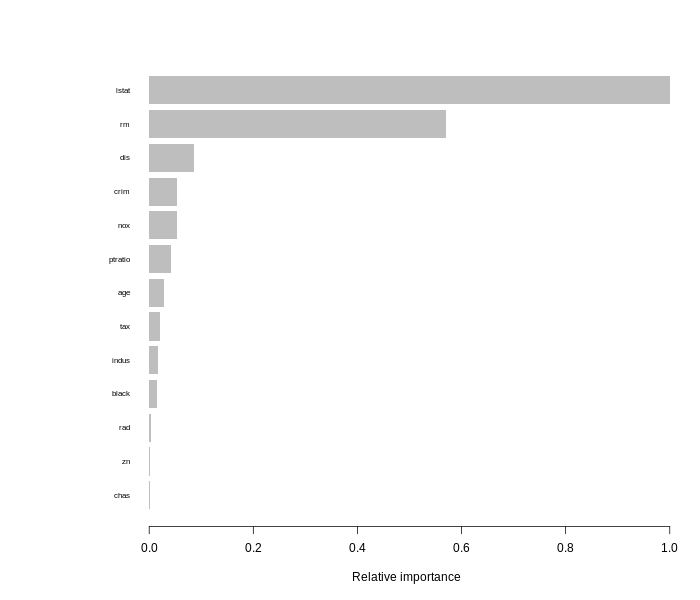

In [ ]:
%%R -w 700 -h 600 -u px
# Calculate variable importance
importance <- xgb.importance(model = final_model)
xgb.plot.importance(importance, rel_to_first = TRUE, xlab = "Relative importance")

#### Early Stopping

Early stopping in XGBoost is a technique used to prevent overfitting by monitoring the model's performance on a validation set during training. If the model's performance does not improve for a specified number of rounds (defined by `early_stopping_rounds`), training is halted. This helps to find the optimal number of boosting rounds without excessive computation and ensures that the model generalizes well to unseen data.

In XGBoost, this is implemented by monitoring a performance metric (e.g., RMSE for regression) on a validation dataset during training. If the metric does not improve for a defined number of consecutive rounds (early_stopping_rounds), training stops, and the model returns the iteration with the best performance. This helps select an optimal number of boosting rounds (nrounds) without overfitting to the training data.

In [ ]:
%%R
# Train final model with best parameters
final_model_early <- xgb.train(
  params = best_params,
  data = dtrain,
  nrounds = best_params$nrounds,
  watchlist = list(train = dtrain, test = dtest),
  early_stopping_rounds = 10,
  verbose = 1  # Show training progress
)

[02:03:29] WARNING: src/learner.cc:767: 
Parameters: { "nrounds" } are not used.

[1]	train-rmse:21.638485	test-rmse:21.775883 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[2]	train-rmse:19.595134	test-rmse:19.682217 
[3]	train-rmse:17.738096	test-rmse:17.877446 
[4]	train-rmse:16.116296	test-rmse:16.332263 
[5]	train-rmse:14.662949	test-rmse:14.852240 
[6]	train-rmse:13.368751	test-rmse:13.665619 
[7]	train-rmse:12.131636	test-rmse:12.454425 
[8]	train-rmse:11.025802	test-rmse:11.364955 
[9]	train-rmse:10.028260	test-rmse:10.400720 
[10]	train-rmse:9.162763	test-rmse:9.565926 
[11]	train-rmse:8.373756	test-rmse:8.835636 
[12]	train-rmse:7.655286	test-rmse:8.154447 
[13]	train-rmse:6.977153	test-rmse:7.562153 
[14]	train-rmse:6.390442	test-rmse:7.103871 
[15]	train-rmse:5.848049	test-rmse:6.618085 
[16]	train-rmse:5.363889	test-rmse:6.197285 
[17]	train-rmse:4.943103	test-rmse:5.873801 
[18]	train-r

In [ ]:
%%R
# Evaluate the model with early stopping
yhat_train_early <- predict(final_model_early, train_x)
yhat_test_early <- predict(final_model_early, test_x)

# Train and test RMSE
rmse_train_early <- RMSE(train_y, yhat_train_early)
rmse_test_early <- RMSE(test_y, yhat_test_early)

# Print results
cat("Early Stopping Training RMSE:", rmse_train_early, "\n")
cat("Early Stopping Testing RMSE:", rmse_test_early, "\n")
cat("Best Iteration:", final_model_early$best_iteration, "\n")

Early Stopping Training RMSE: 0.4183715 
Early Stopping Testing RMSE: 3.553561 
Best Iteration: 61 


### Classification with XGBoost

In this section, we will use the XGBoost package to perform classification on a dataset. We will load the dataset, preprocess it, and then fit an XGBoost model for classification. The dataset will be split into training and testing sets, and we will evaluate the model's performance using accuracy and confusion matrix.

#### Data and Data Preparation

We will use`health insurance` dataset to predict the product type (A, B, or C) based on various features such as age, household size, position level, and absence records.

In [ ]:
%%R
data <-readr::read_csv("https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/health_insurance.csv")
# Convert gender to numeric (Male: 0, Female: 1)
data$gender <- as.numeric(factor(data$gender, levels = c("Male", "Female"))) - 1

# Convert product to numeric labels (A: 0, B: 1, C: 2)
data$product <- as.numeric(factor(data$product, levels = c("A", "B", "C"))) - 1

# Select features and target
features <- c("age", "household", "position_level", "absent", "gender")
X <- data[, features]
y <- data$product
# Split data into training (80%) and test (20%) sets using base R
set.seed(123)
n <- nrow(data)
train_indices <- sample(1:n, size = 0.8 * n, replace = FALSE)
X_train <- X[train_indices, ]
y_train <- y[train_indices]
X_test <- X[-train_indices, ]
y_test <- y[-train_indices]

Rows: 1448 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): product, gender
dbl (4): age, household, position_level, absent

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Convert data to DMatrix format for XGBoost

In [ ]:
%%R
# Convert data to DMatrix format for XGBoost
dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = y_train)
dtest <- xgb.DMatrix(data = as.matrix(X_test), label = y_test)

#### Fit lightGBM Classification Model

In [ ]:
%%R
# Initial model training with default parameters
params <- list(
  objective = "multi:softmax",
  num_class = 3,
  eval_metric = "merror",
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 0.8,
  min_child_weight = 1,
  subsample = 0.8
)

initial_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,
  watchlist = list(train = dtrain, test = dtest),
  early_stopping_rounds = 10,
  verbose = 0
)

#### Predictions and Evaluation



In [ ]:
%%R
# Predict on test set
y_pred_initial <- predict(initial_model, dtest)

# Evaluate performance
confusion_matrix_initial <- table(Predicted = y_pred_initial, Actual = y_test)
accuracy_initial <- sum(diag(confusion_matrix_initial)) / sum(confusion_matrix_initial)

# Print results
cat("\nTest Set Accuracy:", round(accuracy_initial, 4), "\n")
cat("\nConfusion Matrix:\n")
print(confusion_matrix_initial)


Test Set Accuracy: 0.8034 

Confusion Matrix:
         Actual
Predicted  0  1  2
        0 80  2 10
        1 17 84 13
        2  7  8 69


#### Hyperparameter Tuning for the Best Parameters

##### Define Parameter Grid and Initialize Variables

In [ ]:
%%R
# Cross-validation for hyperparameter tuning
param_grid <- expand.grid(
  max_depth = c(3, 6, 9),
  eta = c(0.1, 0.3, 0.5),
  min_child_weight = c(1, 3, 5)
)

best_params <- NULL
best_error <- Inf
cv_results <- data.frame()

for (i in 1:nrow(param_grid)) {
  params_cv <- list(
    objective = "multi:softmax",
    num_class = 3,
    eval_metric = "merror",
    max_depth = param_grid$max_depth[i],
    eta = param_grid$eta[i],
    gamma = 0,
    colsample_bytree = 0.8,
    min_child_weight = param_grid$min_child_weight[i],
    subsample = 0.8
  )

  cv_model <- xgb.cv(
    params = params_cv,
    data = dtrain,
    nrounds = 200,
    nfold = 5,
    early_stopping_rounds = 10,
    verbose = 0
  )

  min_error <- min(cv_model$evaluation_log$test_merror_mean)
  best_nrounds <- which.min(cv_model$evaluation_log$test_merror_mean)

  cv_results <- rbind(cv_results, data.frame(
    max_depth = param_grid$max_depth[i],
    eta = param_grid$eta[i],
    min_child_weight = param_grid$min_child_weight[i],
    test_merror = min_error,
    nrounds = best_nrounds
  ))

  if (min_error < best_error) {
    best_error <- min_error
    best_params <- params_cv
    best_params$nrounds <- best_nrounds
  }
}

##### The Best Parameters

In [ ]:
%%R
# Print results
cat("Best Parameters:\n")
print(best_params)

Best Parameters:
$objective
[1] "multi:softmax"

$num_class
[1] 3

$eval_metric
[1] "merror"

$max_depth
[1] 3

$eta
[1] 0.3

$gamma
[1] 0

$colsample_bytree
[1] 0.8

$min_child_weight
[1] 3

$subsample
[1] 0.8

$nrounds
[1] 12



##### Train Final Model with Best Parameters

In [ ]:
%%R
# Train final model with best parameters
final_model <- xgb.train(
  params = best_params,
  data = dtrain,
  nrounds = best_params$nrounds,
  watchlist = list(train = dtrain, test = dtest),
  verbose = 0
)

[19:19:40] WARNING: src/learner.cc:767: 
Parameters: { "nrounds" } are not used.



##### Predictions and Evaluation

In [ ]:
%%R
# Predict on test set
y_pred <- predict(final_model, dtest)

# Evaluate performance
confusion_matrix <- table(Predicted = y_pred, Actual = y_test)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)


cat("\nTest Set Accuracy:", round(accuracy, 4), "\n")
cat("\nConfusion Matrix:\n")
print(confusion_matrix)


Test Set Accuracy: 0.8103 

Confusion Matrix:
         Actual
Predicted  0  1  2
        0 87  5 14
        1 17 85 15
        2  0  4 63


##### Feature Importance



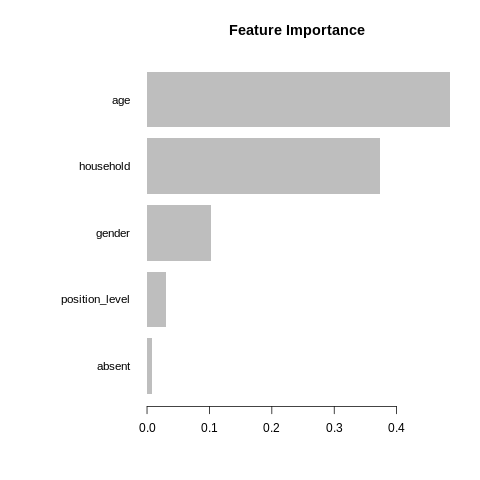

In [ ]:
%%R
# Save feature importance plot
importance <- xgb.importance(feature_names = colnames(X_train), model = final_model)
xgb.plot.importance(importance, main = "Feature Importance")

## Summary and Conclusion

XGBoost is a powerful gradient boosting algorithm that iteratively builds decision trees to minimize a regularized objective function. It uses first- and second-order gradients to optimize tree construction, incorporates regularization to prevent overfitting, and leverages efficient algorithms for scalability. The key equations involve the objective function, gradient/Hessian calculations, and the gain metric for tree splitting, enabling robust and accurate predictions. This R-tutorials covered the implementation of XGBoost for both regression and classification tasks, demonstrating its flexibility and effectiveness in handling complex datasets. The manual implementation provided a deeper understanding of the underlying mechanics, while the use of the `{xgboost}` package showcased its practical application in real-world scenarios.


## References

1.  Chen, T., & Guestrin, C. (2016). *XGBoost: A Scalable Tree Boosting System*. In *KDD '16* (pp. 785–794). arXiv:1603.02754.

2.  Kuhn, M., & Johnson, K. (2019). *Applied Predictive Modeling*. Springer. ISBN: 978-1461468486.

3.  Zhang, Y., & Haghani, A. (2015). *A gradient boosting method to improve travel time prediction*. *Transportation Research Part C*, 58, 308–324. DOI: 10.1016/j.trc.2015.02.019.

4.  [XGBoost in R: A Step-by-Step Example DataCamp](https://www.datacamp.com/community/tutorials/xgboost-in-r)

5.  [Machine Learning with XGBoost in R](Towards%20Data%20Science.%20https://towardsdatascience.com/machine-learning-with-xgboost-in-r)

6.  [Gradient Boosting and Parameter Tuning in R](https://www.kaggle.com/code/camnugent/gradient-boosting-and-parameter-tuning-in-r/)

7. [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/index.html)

